<a href="https://colab.research.google.com/github/wescamargo/aulas/blob/master/Artigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CÓDIGO FONTE - ARTIGO IA POS 2020 Q1**
Código fonte para reprodução do artigo Carbonneau 2008 et al, e proposta de melhoria.

Alunos:
*   Weslei Camargo
*   Leandro Genovesi
*   Lucas Heck




## IMPORTAÇÃO DO GDRIVE E MONTAGEM DO CD

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd "/content/drive/My Drive/UFABC/source"
!ls

/content/drive/My Drive/UFABC/source
Artigo.ipynb  dataset  generate_data.py  __pycache__


## IMPORTAÇÃO DAS BIBLIOTECAS

In [0]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

sns.set(style="whitegrid")
sns.set(rc={"xtick.bottom" : True, 
            "ytick.left" : True,
            "figure.figsize":(22,8)}
        )
pd.options.display.max_columns = 10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## IMPORTAÇÃO DO DATASET

    REF_DATE   VALUE  CHANGE_OVER_NEXT_MONTHS     TODAY     LAG_1     LAG_2  \
0 1992-06-01  163213                -0.188392  0.037024  0.054661  0.002971   
1 1992-07-01  132465                 0.108678 -0.188392  0.037024  0.054661   
2 1992-08-01  146861                 0.094797  0.108678 -0.188392  0.037024   
3 1992-09-01  160783                -0.016289  0.094797  0.108678 -0.188392   
4 1992-10-01  158164                -0.027579 -0.016289  0.094797  0.108678   

      LAG_3     LAG_4  
0  0.104154  0.055124  
1  0.002971  0.104154  
2  0.054661  0.002971  
3  0.037024  0.054661  
4 -0.188392  0.037024  



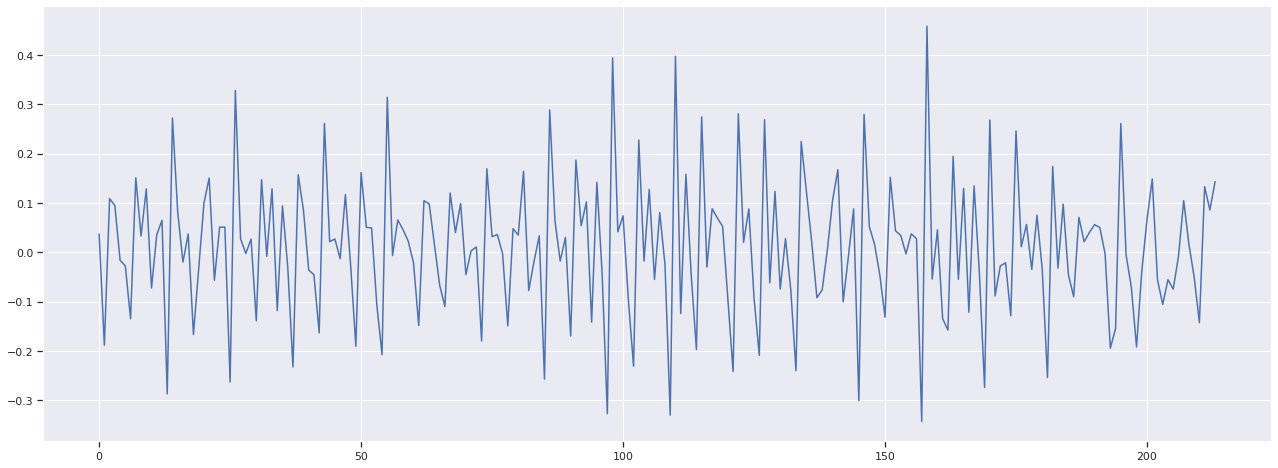

In [0]:
import generate_data

scaler = MinMaxScaler(feature_range=(0.01, 1))
carbonneau = generate_data.carbonneau_data(date_max="2010-03", lags=4)
training_set, testing_set, validation_set, scaler = generate_data.carbonneau_holdout(carbonneau, scaler=scaler)

print(carbonneau.head())
print()
plt.plot(carbonneau.index, carbonneau.TODAY)

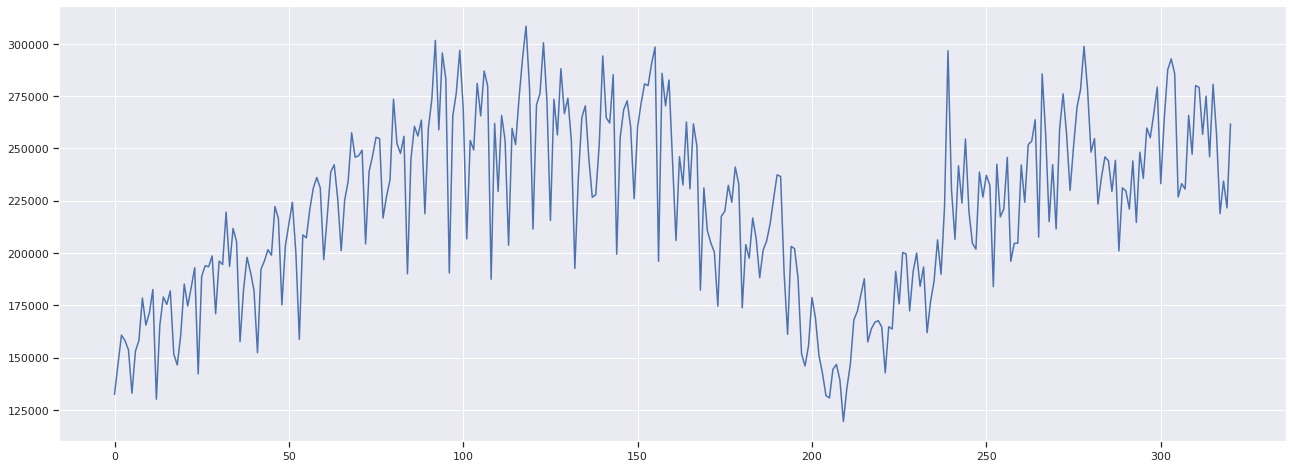

In [0]:
plt.plot(carbonneau.index, carbonneau.VALUE)

In [0]:
# ta dando erro, ignorar por enquanto
#!pip install git+https://github.com/statsmodels/statsmodels.git
from statsmodels.tsa.seasonal import STL
stl = STL(carbonneau.VALUE.values, seasonal=13, period=12)
res = stl.fit()
fig = res.plot()

ImportError: ignored

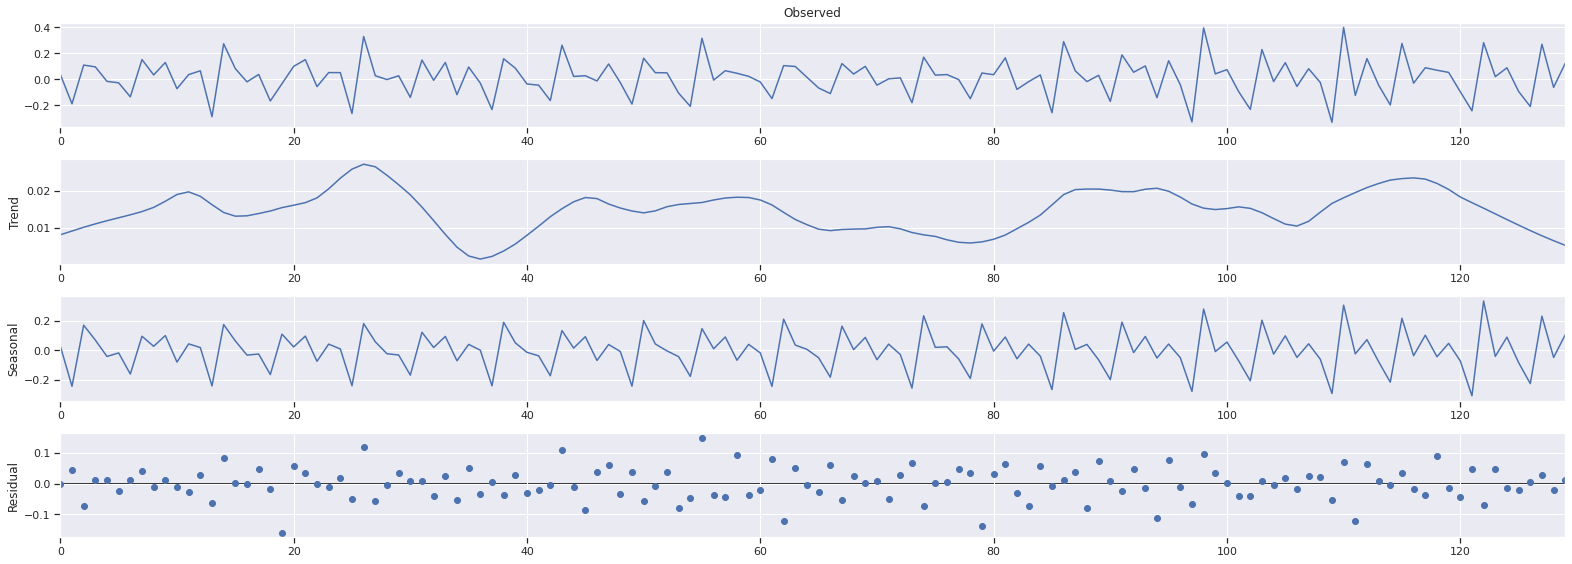

In [0]:
stl = STL(carbonneau.TODAY.values, seasonal=13, period=12)
res = stl.fit()
fig = res.plot()

# Métodos Estatísticos

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## NAIVE


Mean Absolute Error: 0.16301615853115936
MAPE: 275.05937840242


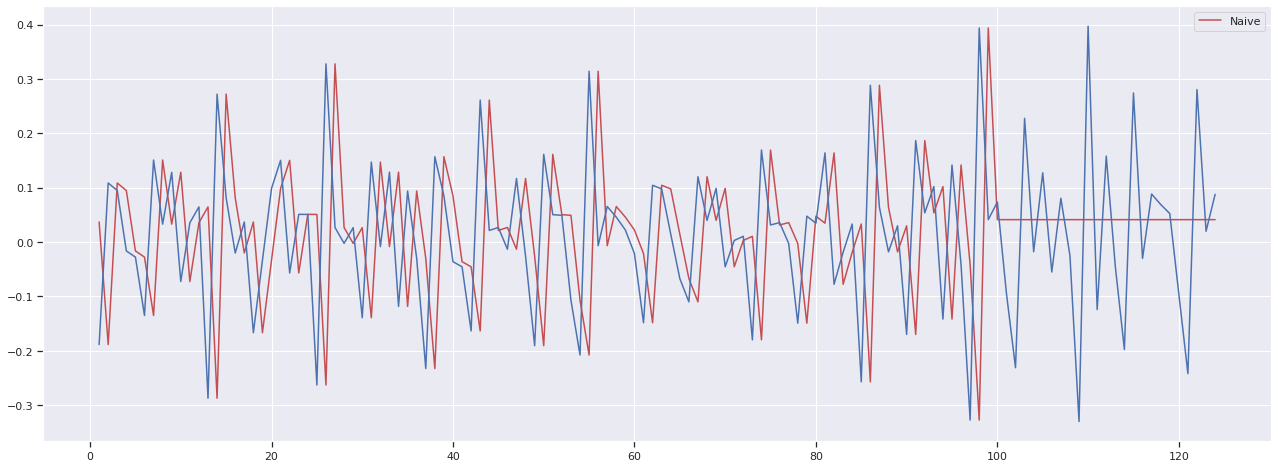

In [0]:
predict = carbonneau.TODAY.loc[:100].shift(1)
predict = predict.append( predict.iloc[[-1]*24] ).reset_index(drop=True)
predict = predict.dropna()
plt.plot(predict, color='r', label="Naive")
plt.plot(carbonneau.TODAY.loc[1:124], color='b')
plt.legend();
print('Mean Absolute Error:', mean_absolute_error(carbonneau.TODAY.loc[1:124], predict))
print('MAPE:', mean_absolute_percentage_error(carbonneau.TODAY.loc[1:124], predict))

## HOLT WINTERS

*O algoritmo não foi eu quem fiz, só apliquei direto, então tem que dar uma olhada se ta tudo certo.*

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)



Mean Absolute Error: 0.07017848963110529
MAPE: 81.28896309626344


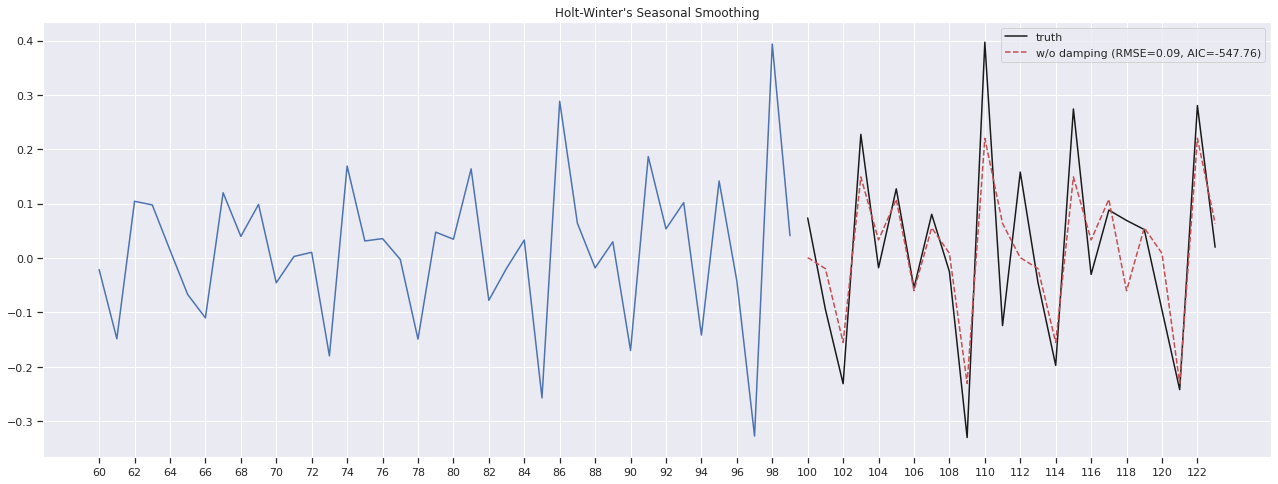

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = carbonneau.TODAY[:100]
test = carbonneau.TODAY[100:124]

holt_winters_model = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=12)
holt_winters_model = holt_winters_model.fit()

pred = holt_winters_model.forecast(24)

sse = np.sqrt(mean_squared_error(test, pred))

print()
print('Mean Absolute Error:', mean_absolute_error(test, pred))
print('MAPE:', mean_absolute_percentage_error(test, pred))

fig, ax = plt.subplots(figsize=(22, 8))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth', color='k',);
ax.plot(test.index, pred, linestyle='--', color='r', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse, holt_winters_model.aic));
ax.legend();
plt.xticks(range(60, max(test.index), 2));
ax.set_title("Holt-Winter's Seasonal Smoothing");

## Damped

> Com esse só tou conseguindo rodar utilizando a coluna __VALUE__, que tem tendência. Quando tento usar a coluna __TODAY__ (variação do __VALUE__ do mes anterior para o atual) da um erro e os valores do __forecast__ dão __nan__.

Vou deixar isso ai, mas só pra entender o problema. É que o __damped__ só funciona pra `trend != None`, só que usando __TODAY__ não tem tendência alguma, então obviamente temos que usar o __VALUE__ que tem tendência.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)



Mean Absolute Error: 13363.417092121874
MAPE: 5.52124254198918


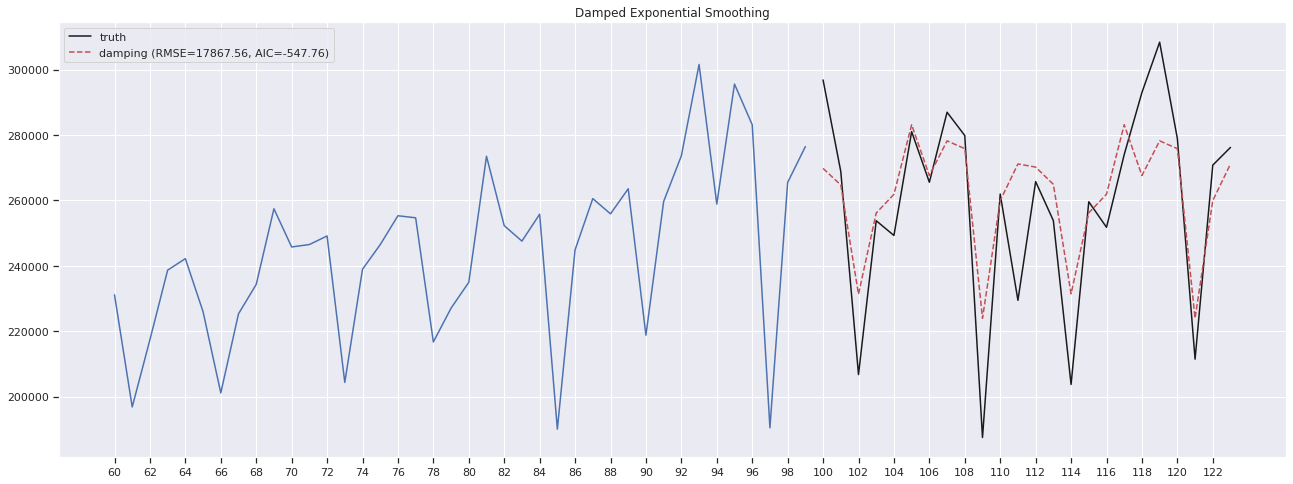

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = carbonneau.VALUE[:100]
test = carbonneau.VALUE[100:124]

damped_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True,)
damped_model = damped_model.fit(use_boxcox=False)

pred = damped_model.forecast(24)

sse = np.sqrt(mean_squared_error(test, pred))
print()
print('Mean Absolute Error:', mean_absolute_error(test, pred))
print('MAPE:', mean_absolute_percentage_error(test, pred))

fig, ax = plt.subplots(figsize=(22, 8))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth', color='k',);
ax.plot(test.index, pred, linestyle='--', color='r', label="damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse, holt_winters_model.aic));
ax.legend();
plt.xticks(range(60, max(test.index), 2));
ax.set_title("Damped Exponential Smoothing");

## ARIMA

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Só testando, estudar e melhorar mais depois se precisar (se der vontade e tempo).


In [0]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 


In [0]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(carbonneau.TODAY[:100], start_p=1, start_q=1,
                         test='adf', trend='c',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=-236.441, BIC=-224.054, Time=0.758 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=-209.605, BIC=-204.650, Time=0.059 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=-218.457, BIC=-208.548, Time=0.285 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=-238.500, BIC=-228.591, Time=1.116 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=-209.605, BIC=-204.650, Time=0.058 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=-225.185, BIC=-215.276, Time=0.242 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=-239.983, BIC=-225.119, Time=1.448 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse r

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  100
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 127.754
Date:                              Thu, 26 Mar 2020   AIC                           -245.509
Time:                                      22:22:20   BIC                           -233.122
Sample:                                           0   HQIC                          -240.518
                                              - 100                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.504e-05      0.002     -0.016      0.987      -0.004       0.004
ar.L1         -0.5677      0.112     -5.051      0.000      -0.788      -0.347
ar.L2         -0.4916      0.126     -3.916      0.000      -0.738      -0.246
ma.S.L12      -0.9715      1.509     -0.644      0.520      -3.930       1.987
sigma2         0.0025      0.004      0.675      0.500      -0.005       0.010
===================================================================================
Ljung-Box (Q):                       57.54   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.04   Prob(JB):                         0.87
Heteroskedasticity (H):               0.89   Skew:                            -0.06
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Mean Absolute Error: 0.07943820116888263
MAPE: 94.7096346100276


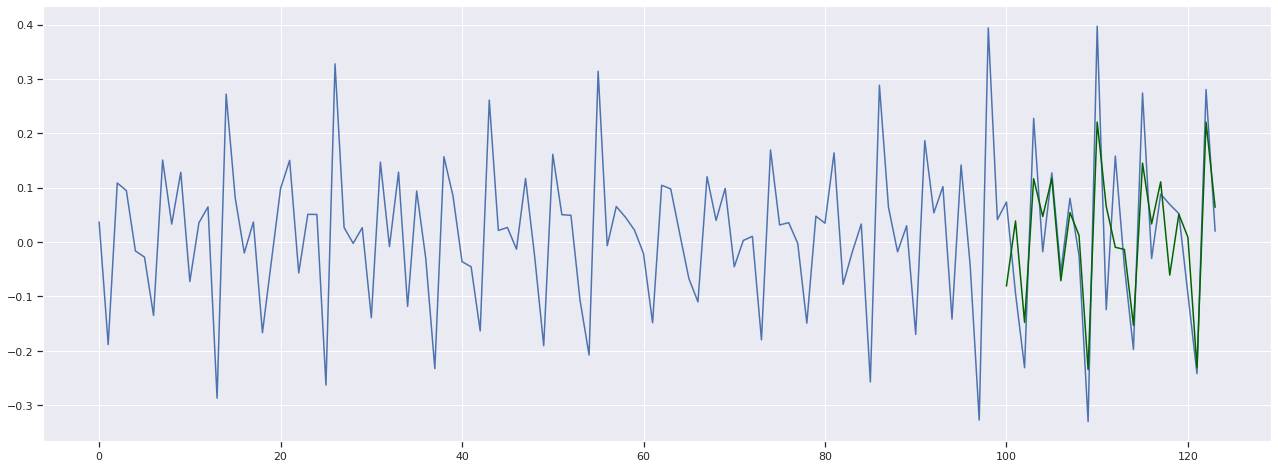

In [0]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

print('Mean Absolute Error:', mean_absolute_error(carbonneau.TODAY.values[100:124], fitted))
print('MAPE:', mean_absolute_percentage_error(carbonneau.TODAY.values[100:124], fitted))

plt.plot(carbonneau.TODAY.values[:124])
plt.plot(range(100,124), fitted, color='darkgreen')

plt.show()

## Resumo

|  | AIC   |
|------|------|
|   Holt-Winter  | -511.64|
|   Damped | -511.64 |
|   ARIMA  | -245.529 |

Quanto menor o AIC melhor, aqui o ARIMA é o muito pior que os outros, então deve ter algo errado com os valores (p,q,d). 

# Métodos de Aprendizado de Máquina

## MLP
**Parâmetros:**
- learning_rate: 0.1
- momentum: 0.7
- ativação camada oculta: tanh
- ativação saida: linear
- epochs: 500?

In [0]:
# Define a simple sequential model
def create_mlp_model(input_shape, learning_rate=0.1):
    model = tf.keras.models.Sequential([
        keras.layers.Dense(3, activation="tanh", input_dim=input_shape),
        keras.layers.Dense(1, activation="linear")
    ])

    # talvez colocar no artigo pq usar tanh e nao outra.

    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.7, nesterov=True)
    model.compile(optimizer=sgd, 
              loss='mae', 
              metrics=["mae","mape"],)

    return model

# Create a basic model instance
mlp_model = create_mlp_model(input_shape=5)

# Display the model's architecture
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time

lista_epochs=[10,50,100,250,500,1000,10000]
for epoch in lista_epochs:
    mlp_model = create_mlp_model(5)
    history = mlp_model.fit(training_set[0], training_set[1], 
                #validation_size=0.2,    
                validation_data=(validation_set[0], validation_set[1]),
                epochs=epoch,
                verbose=0,
                shuffle=True,)

    history_test = mlp_model.evaluate(testing_set[0], testing_set[1], verbose=0)
    print("EPOCHAS:", epoch)
    print("MAE training:", history.history["mae"][-1],
        "MAPE training:", history.history["mape"][-1])
    print("MAE validation:", history.history["val_mae"][-1],
        "MAPE validation:", history.history["val_mape"][-1])
    print("MAE testing:", history_test[1],
        "MAPE testing:", history_test[2])
    print("-------------------")


EPOCHAS: 10
MAE training: 0.11912716925144196 MAPE training: 269.66705322265625
MAE validation: 0.162387877702713 MAPE validation: 242.29689025878906
MAE testing: 0.18274328112602234 MAPE testing: 428.2035217285156
-------------------
EPOCHAS: 50
MAE training: 0.13726530969142914 MAPE training: 462.6385803222656
MAE validation: 0.12415095418691635 MAPE validation: 189.193359375
MAE testing: 0.11693160235881805 MAPE testing: 230.09042358398438
-------------------
EPOCHAS: 100
MAE training: 0.11013634502887726 MAPE training: 257.2026672363281
MAE validation: 0.210487499833107 MAPE validation: 360.78955078125
MAE testing: 0.2032928317785263 MAPE testing: 520.1591796875
-------------------
EPOCHAS: 250
MAE training: 0.10152765363454819 MAPE training: 265.33056640625
MAE validation: 0.04532976076006889 MAPE validation: 46.88407897949219
MAE testing: 0.08993938565254211 MAPE testing: 204.3401336669922
-------------------
EPOCHAS: 500
MAE training: 0.08358635008335114 MAPE training: 204.18963

KeyboardInterrupt: ignored

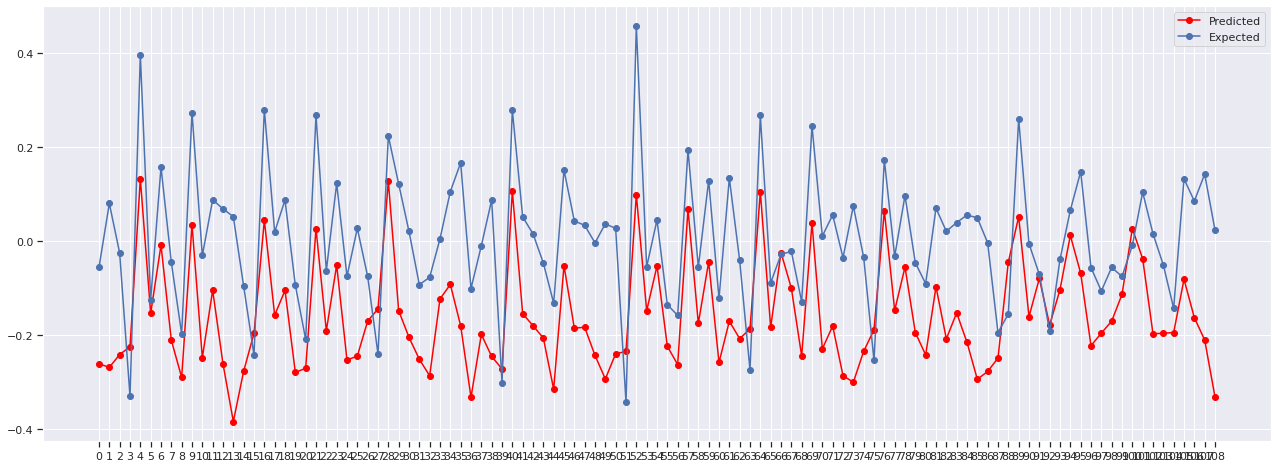

In [0]:
predicted = mlp_model.predict(testing_set[0], verbose=False)
plt.subplots(figsize=(22, 8))
plt.plot(predicted, 'o-', color="red", label="Predicted")
plt.plot(testing_set[1], 'o-', label="Expected")
plt.legend()
plt.xticks(range(len(predicted)));

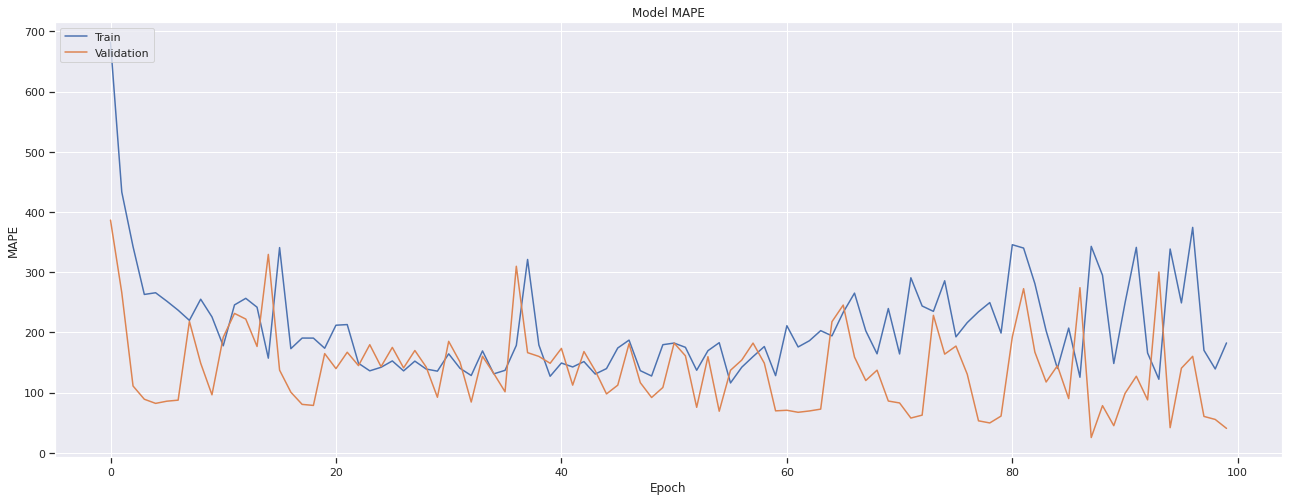

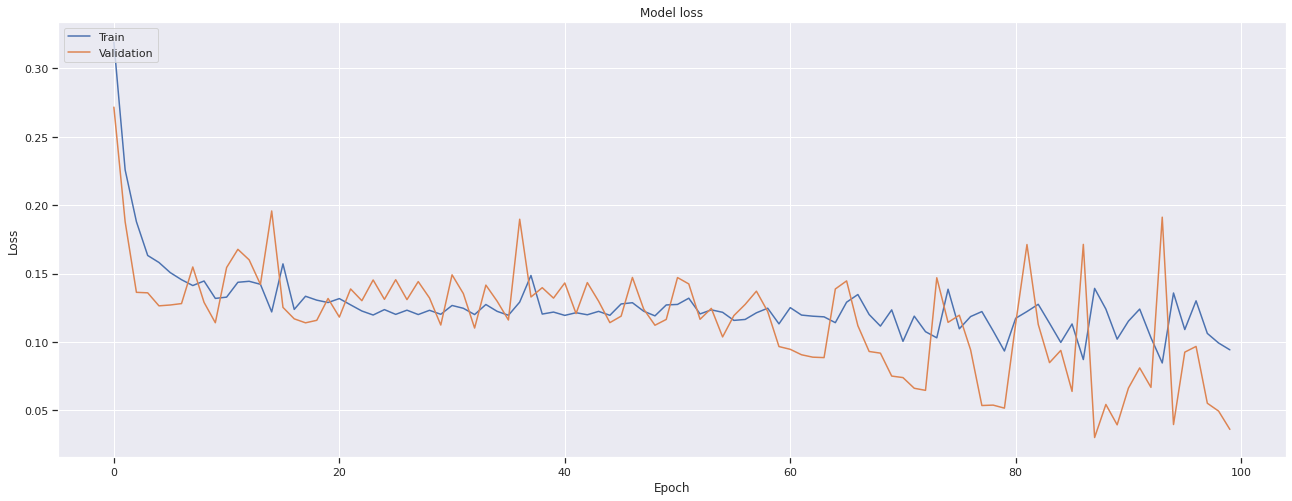

In [0]:
plt.subplots(figsize=(22, 8))
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.subplots(figsize=(22, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

## Multiple MLPs

Os parâmetros aqui são os mesmo da anterior, tanto que usa novamente o __create_mlp_model__, a diferença é que cria um conjunto (_ensemble_ é a palavra mais bonita pra usar kkkkk) de 30 modelos, ajusta cada um separado e obtêm a média da previsão deles para a previsão final.

Quem faz isso é o (Makridakis et al. 2020), ele ainda muda alguns parametros:

- learning_rate: 0.001
- epochs: 100
- optimizer: adam 
- camada oculta: 6 nós
- função ativação de todas as camadas: linear
- dessazonalização e removação de tendência (subtraindo a reta da regressão linear da série dessazonalizada)

Talvez a gente faça esse último ponto lá no ínicio, meio como já fazemos obtendo só a variação, e use assim pra tudo?

E talvez seja mais interessate ver como fica só com o _ensemble_ e depois como fica com esses parâmetros?


In [0]:
%%time
mean_mae_train = []
mean_mae_valid = []
mean_mae_test = []
model_MLP = []
for _ in range(10):
    tmp_model = create_mlp_model(5)

    history = tmp_model.fit(training_set[0], training_set[1], 
              validation_data=(validation_set[0], validation_set[1]),
              epochs=50,
              verbose=0,
              shuffle=True,)
        
    model_MLP.append(copy.copy(tmp_model))
    
    history_test = tmp_model.evaluate(testing_set[0], testing_set[1], verbose=0)
    
    mean_mae_train.append(history.history['mae'][-1])
    mean_mae_valid.append(history.history['val_mae'][-1])
    mean_mae_test.append(history_test[1])

print("MAE médio training:", np.mean(mean_mae_train), 
      "desvio padrão:", np.std(mean_mae_train))
print("MAE médio validation:", np.mean(mean_mae_valid),
      "desvio padrão:", np.std(mean_mae_valid))
print("MAE médio testing:", np.mean(mean_mae_test),
      "desvio padrão:", np.std(mean_mae_test))

MAE médio training: 0.10829015076160431 desvio padrão: 0.016872886849463975
MAE médio validation: 0.10902493372559548 desvio padrão: 0.05104300302094016
MAE médio testing: 0.13016320988535882 desvio padrão: 0.03894245820247167
CPU times: user 22.6 s, sys: 648 ms, total: 23.2 s
Wall time: 22.3 s


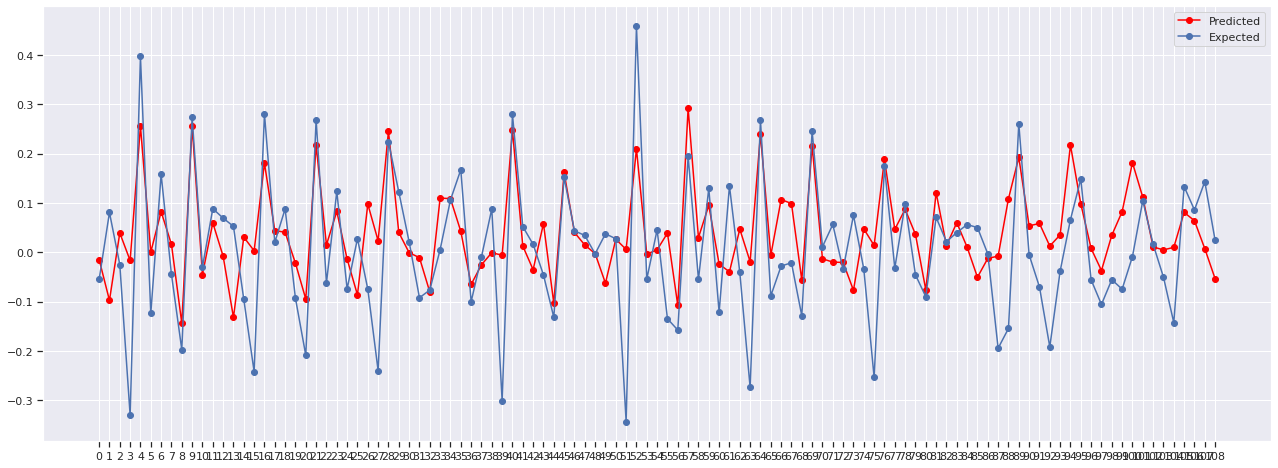

In [0]:
predicted = model_MLP[0].predict(testing_set[0], verbose=False)
for model_i in model_MLP[1:]:
    predicted += model_i.predict(testing_set[0], verbose=False)
predicted /= len(model_MLP)
predicted = [i[0] for i in predicted]

plt.plot(predicted, 'o-', color="red", label="Predicted")
plt.plot(testing_set[1], 'o-', label="Expected")
plt.legend()
plt.xticks(range(len(predicted)));